In [121]:
# %%capture

# !pip install git+https://github.com/huggingface/transformers.git

In [122]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [123]:
import librosa
import torch
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
import numpy as np

In [124]:
import os

In [125]:
data_type = 'TestSetNotPrepped_u'

In [126]:
signals = []

dir = f'/content/drive/MyDrive/CancerVsLaryngitis/DealWithData/{data_type}'

for subdir, dirs, files in os.walk(dir):
  for file in files:
    if file.endswith('.wav'):
      y, sr = librosa.load(subdir+'/'+file, sr=16000)
      if len(y) < 16000:
        y=np.pad(y, (0, 16000-len(y)), 'constant', constant_values=0)
      signals.append(y)

In [127]:
sum_lens = 0
sig_lens=[]
sig_lens_sec=[]

for signal in signals:
  sum_lens+=len(signal)
  sig_lens.append(len(signal))
  sig_lens_sec.append(len(signal)/sr)

In [128]:
av_len = sum_lens/len(signals)
print(av_len)
print(av_len/sr)

20490.8
1.280675


In [129]:
sum(i >= 1 for i in sig_lens_sec)

40

{'whiskers': [<matplotlib.lines.Line2D at 0x7f94b93ffc40>,
 'caps': [<matplotlib.lines.Line2D at 0x7f94b93ff6a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f94b93ff4c0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f94b9282650>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f94b92823b0>],
 'means': []}

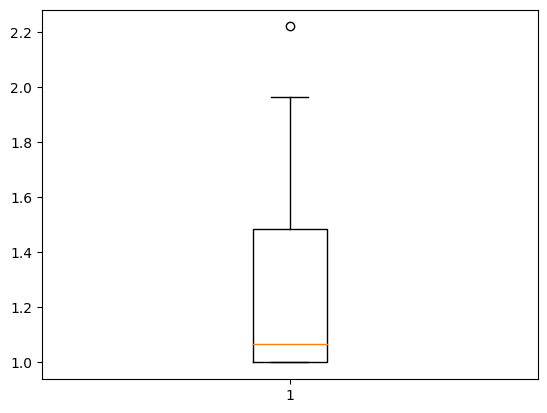

In [130]:
import matplotlib.pyplot as plt
plt.boxplot(sig_lens_sec)

In [131]:
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model

In [132]:
model_name = "facebook/wav2vec2-large-xlsr-53"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
model = Wav2Vec2Model.from_pretrained(model_name)

In [133]:
hidden_states = torch.empty(size=(len(signals), 1024))
feature_states = torch.empty(size=(len(signals), 512))

for x in range(len(signals)):
  i= feature_extractor(signals[x], return_tensors="pt", sampling_rate=sr, padding=True)
  with torch.no_grad():
    o= model(i.input_values)

  sig_hidden_state = torch.mean(o.last_hidden_state, axis=1)
  sig_feature_state = torch.mean(o.extract_features, axis=1)

  hidden_states[x] = sig_hidden_state
  feature_states[x] = sig_feature_state

In [134]:
print(hidden_states.shape)
print(feature_states.shape)

torch.Size([40, 1024])
torch.Size([40, 512])


In [135]:
file_list=[]
pathology_list=[]

for subdir, dirs, files in os.walk(dir):
  for file in files:
    if file.endswith('.wav'):
      file_list.append(file)
      pathology_list.append(subdir.split('/')[-1])

In [136]:
import pandas as pd

In [137]:
df = pd.DataFrame(hidden_states.numpy())
df['file']=file_list
df['pathology']=pathology_list

In [138]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1016,1017,1018,1019,1020,1021,1022,1023,file,pathology
0,-0.031288,0.216352,0.002254,-0.013515,-0.039533,0.030209,0.046105,0.029137,0.001467,-0.022999,...,0.102140,0.031666,0.007641,0.136655,-0.166413,-0.086373,0.015613,-0.024371,1300-u_n.wav,Laryngitis
1,-0.031114,0.216937,0.002012,-0.013744,-0.041549,0.030076,0.045081,0.028771,0.000738,-0.023743,...,0.101930,0.031974,0.007196,0.134971,-0.167425,-0.086551,0.015734,-0.025577,1404-u_n.wav,Laryngitis
2,-0.031878,0.216240,0.001950,-0.013553,-0.039533,0.030522,0.046593,0.028897,0.000578,-0.023481,...,0.102062,0.032135,0.008038,0.137923,-0.167395,-0.086175,0.015231,-0.025131,1414-u_n.wav,Laryngitis
3,-0.031430,0.213462,0.002189,-0.014078,-0.040438,0.030847,0.046037,0.028630,0.000957,-0.023502,...,0.101820,0.032289,0.007972,0.138513,-0.165555,-0.086517,0.013746,-0.025499,1426-u_n.wav,Laryngitis
4,-0.031029,0.218015,0.001620,-0.013528,-0.040095,0.030844,0.045812,0.029895,0.001652,-0.023834,...,0.102822,0.031873,0.008187,0.137857,-0.163914,-0.083313,0.014295,-0.024723,1567-u_n.wav,Laryngitis


In [139]:
df.shape

(40, 1026)

In [140]:
df.to_csv(f'/content/drive/MyDrive/CancerVsLaryngitis/FeatureSets/NotPrepped/hidden_states_{data_type}.csv')

In [141]:
df = pd.DataFrame(feature_states.numpy())
df['file']=file_list
df['pathology']=pathology_list

In [142]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,504,505,506,507,508,509,510,511,file,pathology
0,0.195447,-0.896807,-0.253969,1.322033,0.485400,0.054690,0.577375,2.118427,-0.867124,-0.281275,...,-1.219681,-1.670302,0.464705,-0.378426,-0.716505,1.000167,1.210681,0.915320,1300-u_n.wav,Laryngitis
1,0.534897,-0.557827,-1.665806,1.333971,0.571936,0.172397,0.439196,1.181502,-0.957219,-0.440511,...,-0.183794,-0.277988,0.712846,2.124380,-0.716815,0.408034,-0.064011,1.143215,1404-u_n.wav,Laryngitis
2,-0.095039,-1.035500,-0.765945,0.727740,0.947781,0.523448,0.144139,-0.755957,-1.457831,0.071357,...,0.879197,5.519957,0.667306,-1.261441,-0.385828,1.151102,0.655889,0.154831,1414-u_n.wav,Laryngitis
3,0.263879,-0.485935,-1.488432,0.223710,0.765852,0.125804,-0.425821,5.910227,-0.611833,-0.025149,...,0.541152,1.020726,0.579640,-0.209593,-0.848334,-0.277914,-0.021207,0.779193,1426-u_n.wav,Laryngitis
4,1.002089,-0.100584,-0.322115,0.705030,0.417691,-0.094193,0.129022,-1.284157,-0.702606,-0.076732,...,0.180627,-1.616648,1.000739,0.300799,-0.917794,0.265142,3.239331,0.354811,1567-u_n.wav,Laryngitis


In [143]:
df.shape

(40, 514)

In [144]:
df.to_csv(f'/content/drive/MyDrive/CancerVsLaryngitis/FeatureSets/NotPrepped/feature_states_{data_type}.csv')